In [808]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [767]:
df = pd.read_csv("./data/cancer_reg.csv", encoding='iso-8859-1')

In [768]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

# EDA

In [769]:
df = df[df['MedianAge'] <= 90]

In [770]:
df = pd.get_dummies(df, columns=['binnedInc'], dtype=int) # Explode. One-hot encoding for binnedInc

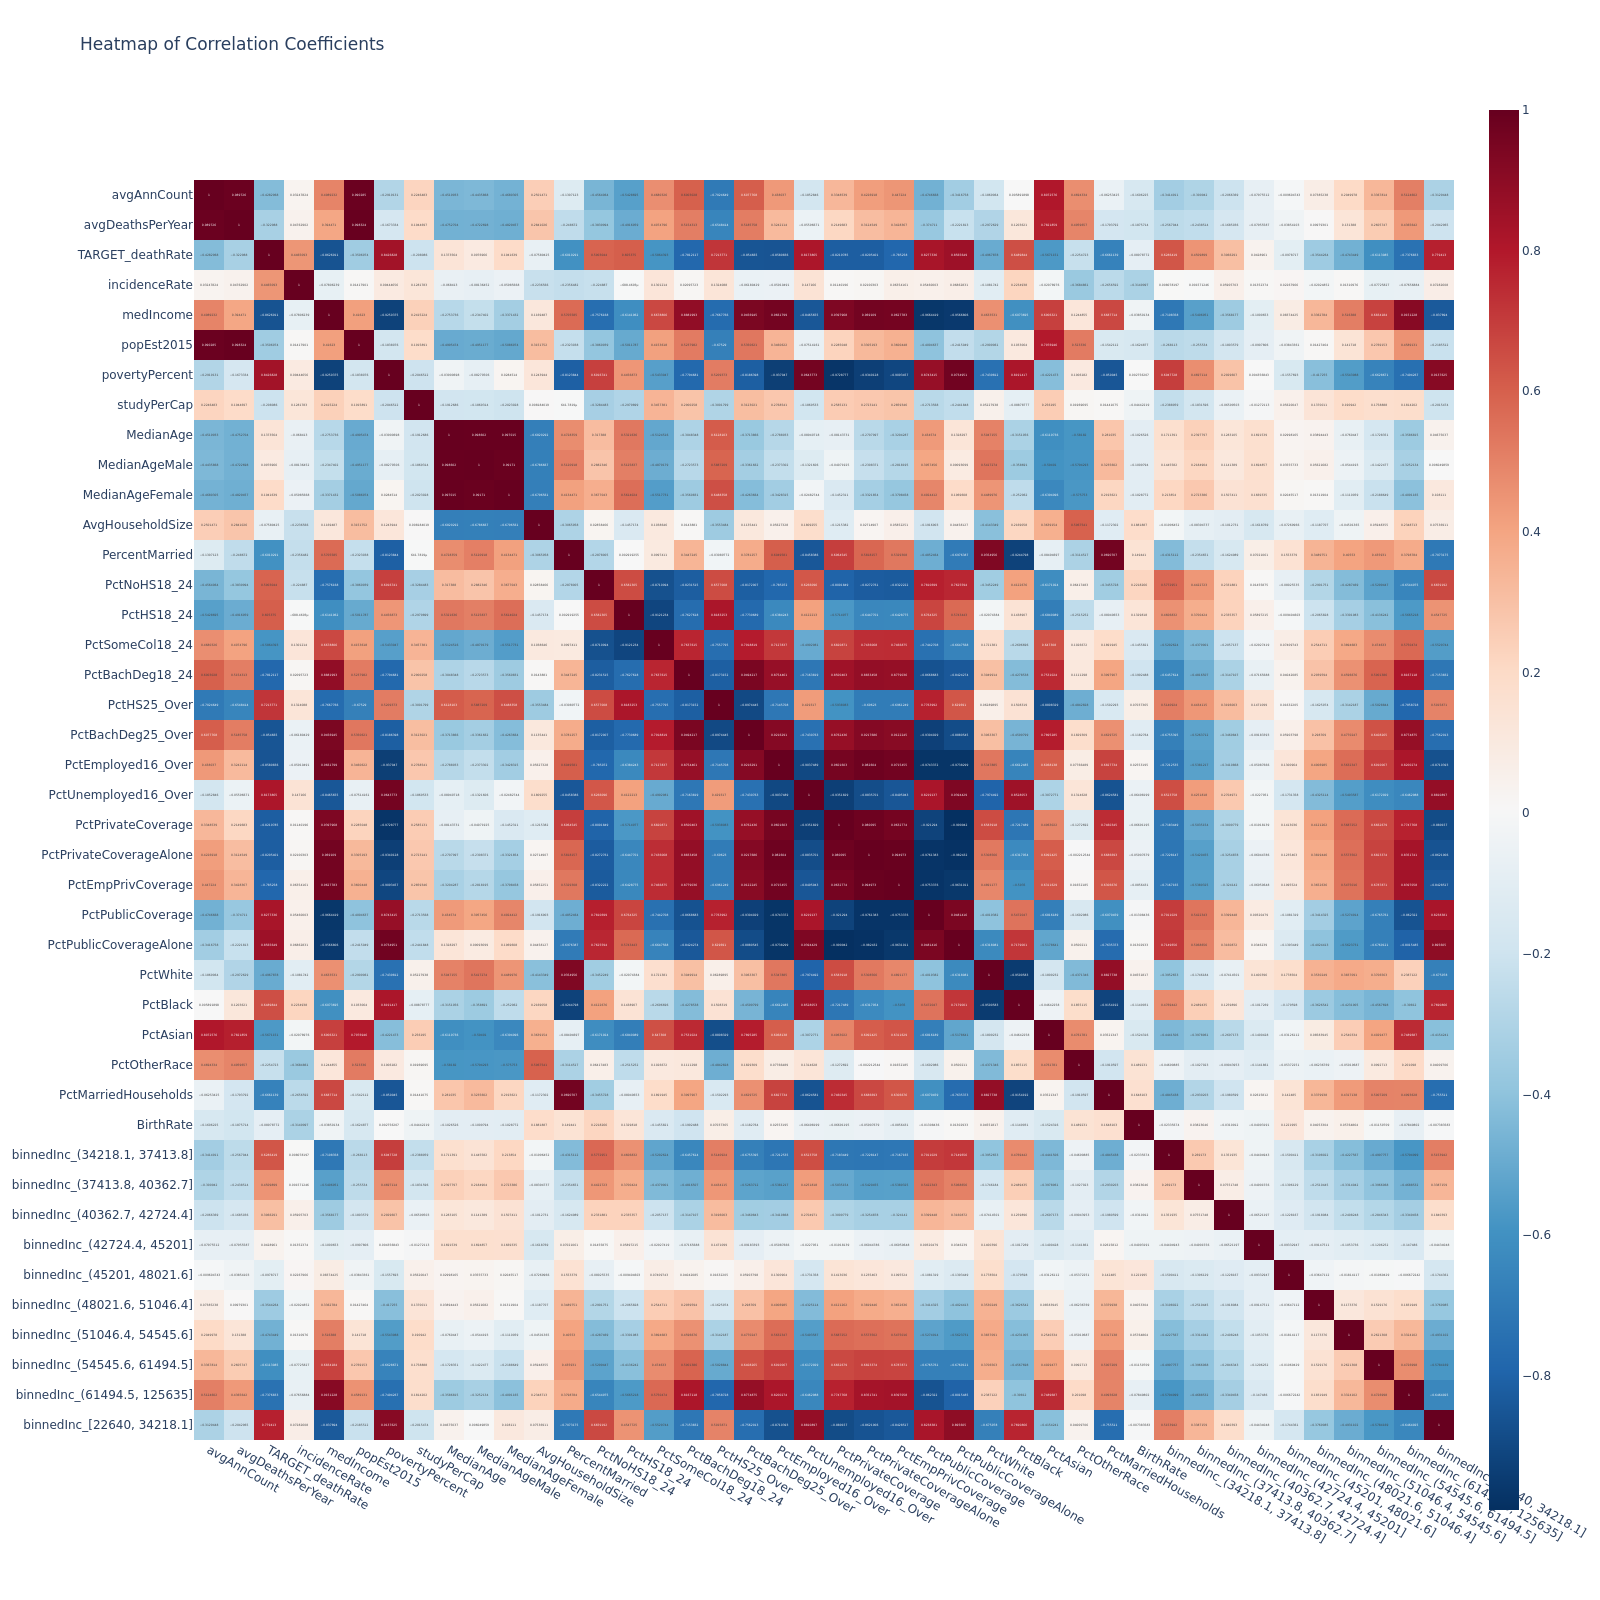

In [771]:
corr_heatmap(df.corr(numeric_only=True), fig_type="png")

In [772]:
def plot_barplot_corr_with_target(df, target='TARGET_deathRate'):
    corr = df.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

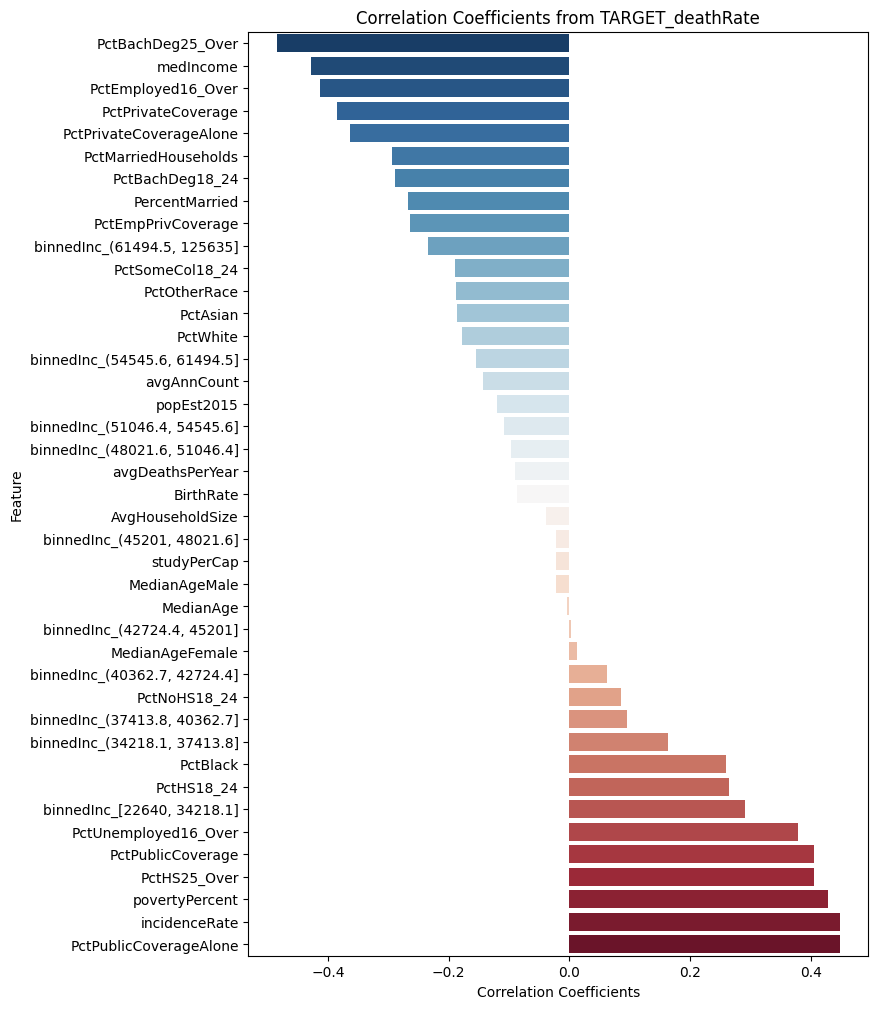

In [773]:
plot_barplot_corr_with_target(df)

# Feature Selection
- avgAnnCount: Mean number of reported cases of cancer diagnosed annually
    - The diagnosis could demonstrate people having a minimal medical treatment.
- incidenceRate: Mean per capita (100,000) cancer diagnoses
    - The diagnosis could demonstrate people having a minimal medical treatment.
- PctPrivateCoverage: Percent of county residents with private health coverage 
    - People that has private health insurance can have a better medical treatment.
- PctPublicCoverage: Percent of county residents with government-provided health coverage 
    - An urge of public health system usage could be a indicative of less people can afford a private health coverage.
- PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor’s degree 
	- Higher education can be an indicative of more income.
- PercentMarried: Percent of county residents who are married 
	- Residents who are married can indicate two incomes in the family, possibly affording the private coverage.
- binnedInc: Median income per capita binned by decile
	- what would I do with this column? Discrete?
- povertyPercent: Percent of populace in poverty
    - Less chance of getting any treatment
- medianIncome: Median income per county
    - Higher median income can be an indicative of less inequality 
- MedianAge: Median age of female county residents 
	- An elderly population may indicate difficulty in facing more severe cancer
- PctWhite
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctBlack
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctAsian
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctOtherRace
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- avgDeathsPerYear
    - Number of reported mortalities due to cancer to "adjust" the estimation
- popEst2015
    - Estimate population to "adjust" the estimation

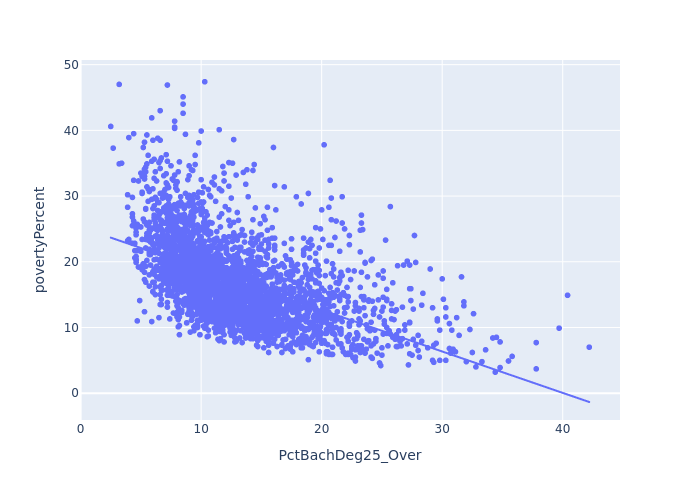

In [774]:
px.scatter(df, x='PctBachDeg25_Over', y='povertyPercent', trendline='ols').show("png")

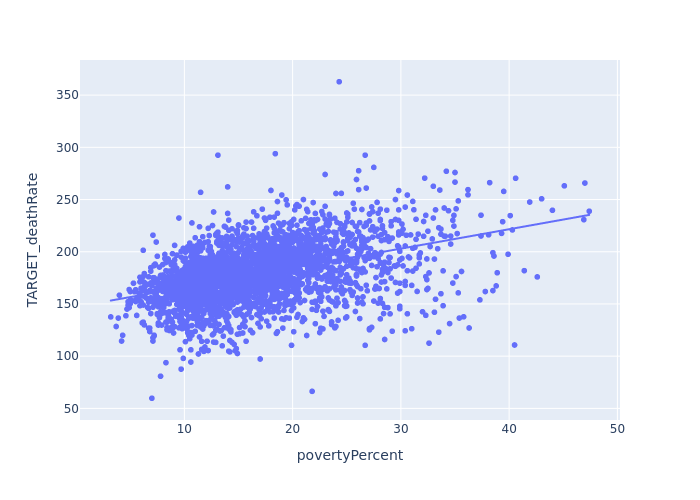

In [775]:
px.scatter(df, x='povertyPercent', y='TARGET_deathRate', trendline='ols').show("png")

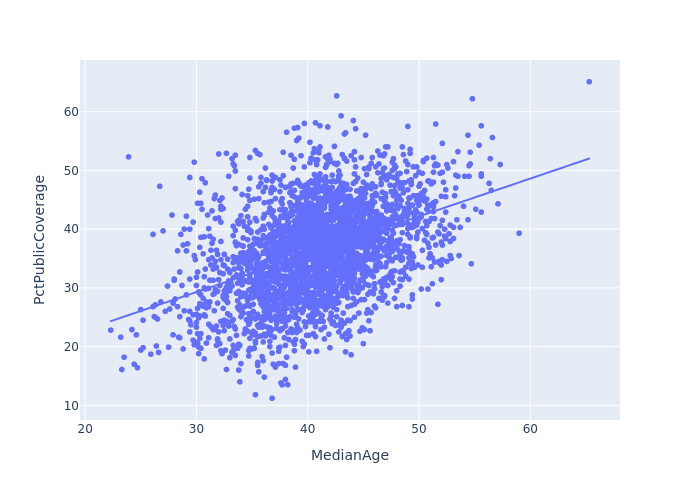

In [776]:
px.scatter(df, x='MedianAge', y='PctPublicCoverage', trendline='ols').show("png")

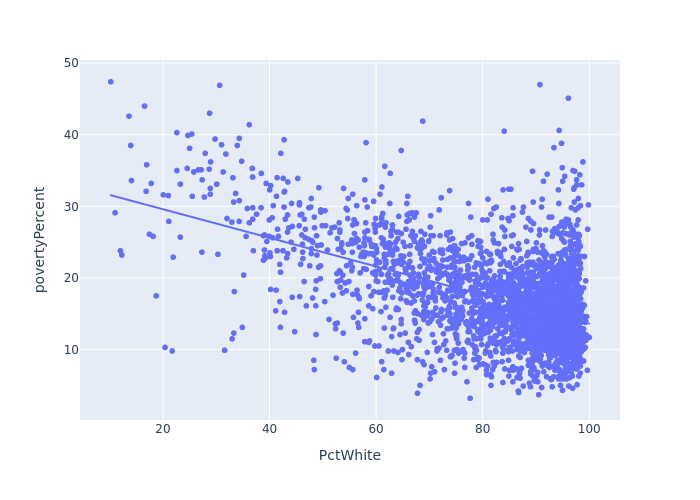

In [777]:
px.scatter(df, x='PctWhite', y='povertyPercent', trendline='ols').show("png")

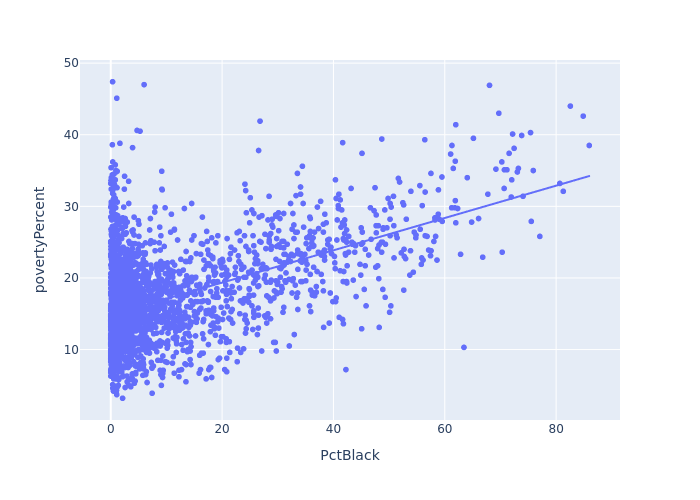

In [778]:
px.scatter(df, x='PctBlack', y='povertyPercent', trendline='ols').show("png")

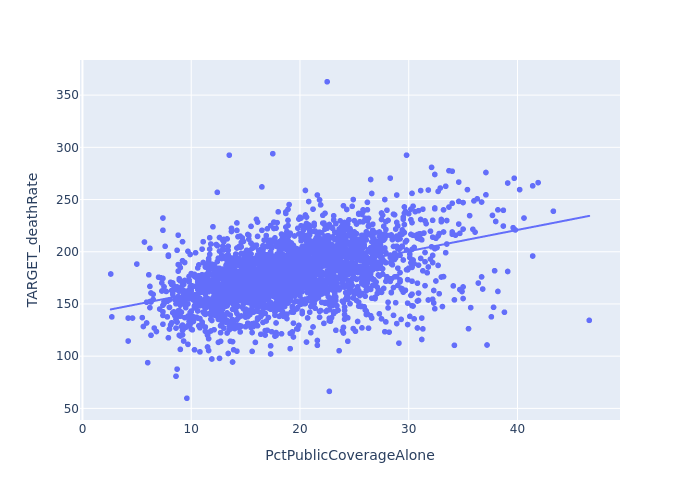

In [779]:
px.scatter(df, x='PctPublicCoverageAlone', y='TARGET_deathRate', trendline='ols').show("png")

In [780]:
features_in = [
"avgAnnCount",
"PctPrivateCoverage",
"PctPublicCoverage",
"PctBachDeg25_Over",
"PercentMarried",
"incidenceRate",
"povertyPercent",
"MedianAge",
"medIncome",
"PctWhite",
"PctBlack",
"PctAsian",
"PctOtherRace",
"avgDeathsPerYear",
"popEst2015",
] + df.columns[df.columns.str.startswith("binnedInc_")].tolist()

In [781]:
features_out = df.columns[~(df.columns.isin(features_in)) & (df.columns != 'TARGET_deathRate')].tolist()

In [782]:
features_out

['studyPerCap',
 'MedianAgeMale',
 'MedianAgeFemale',
 'Geography',
 'AvgHouseholdSize',
 'PctNoHS18_24',
 'PctHS18_24',
 'PctSomeCol18_24',
 'PctBachDeg18_24',
 'PctHS25_Over',
 'PctEmployed16_Over',
 'PctUnemployed16_Over',
 'PctPrivateCoverageAlone',
 'PctEmpPrivCoverage',
 'PctPublicCoverageAlone',
 'PctMarriedHouseholds',
 'BirthRate']

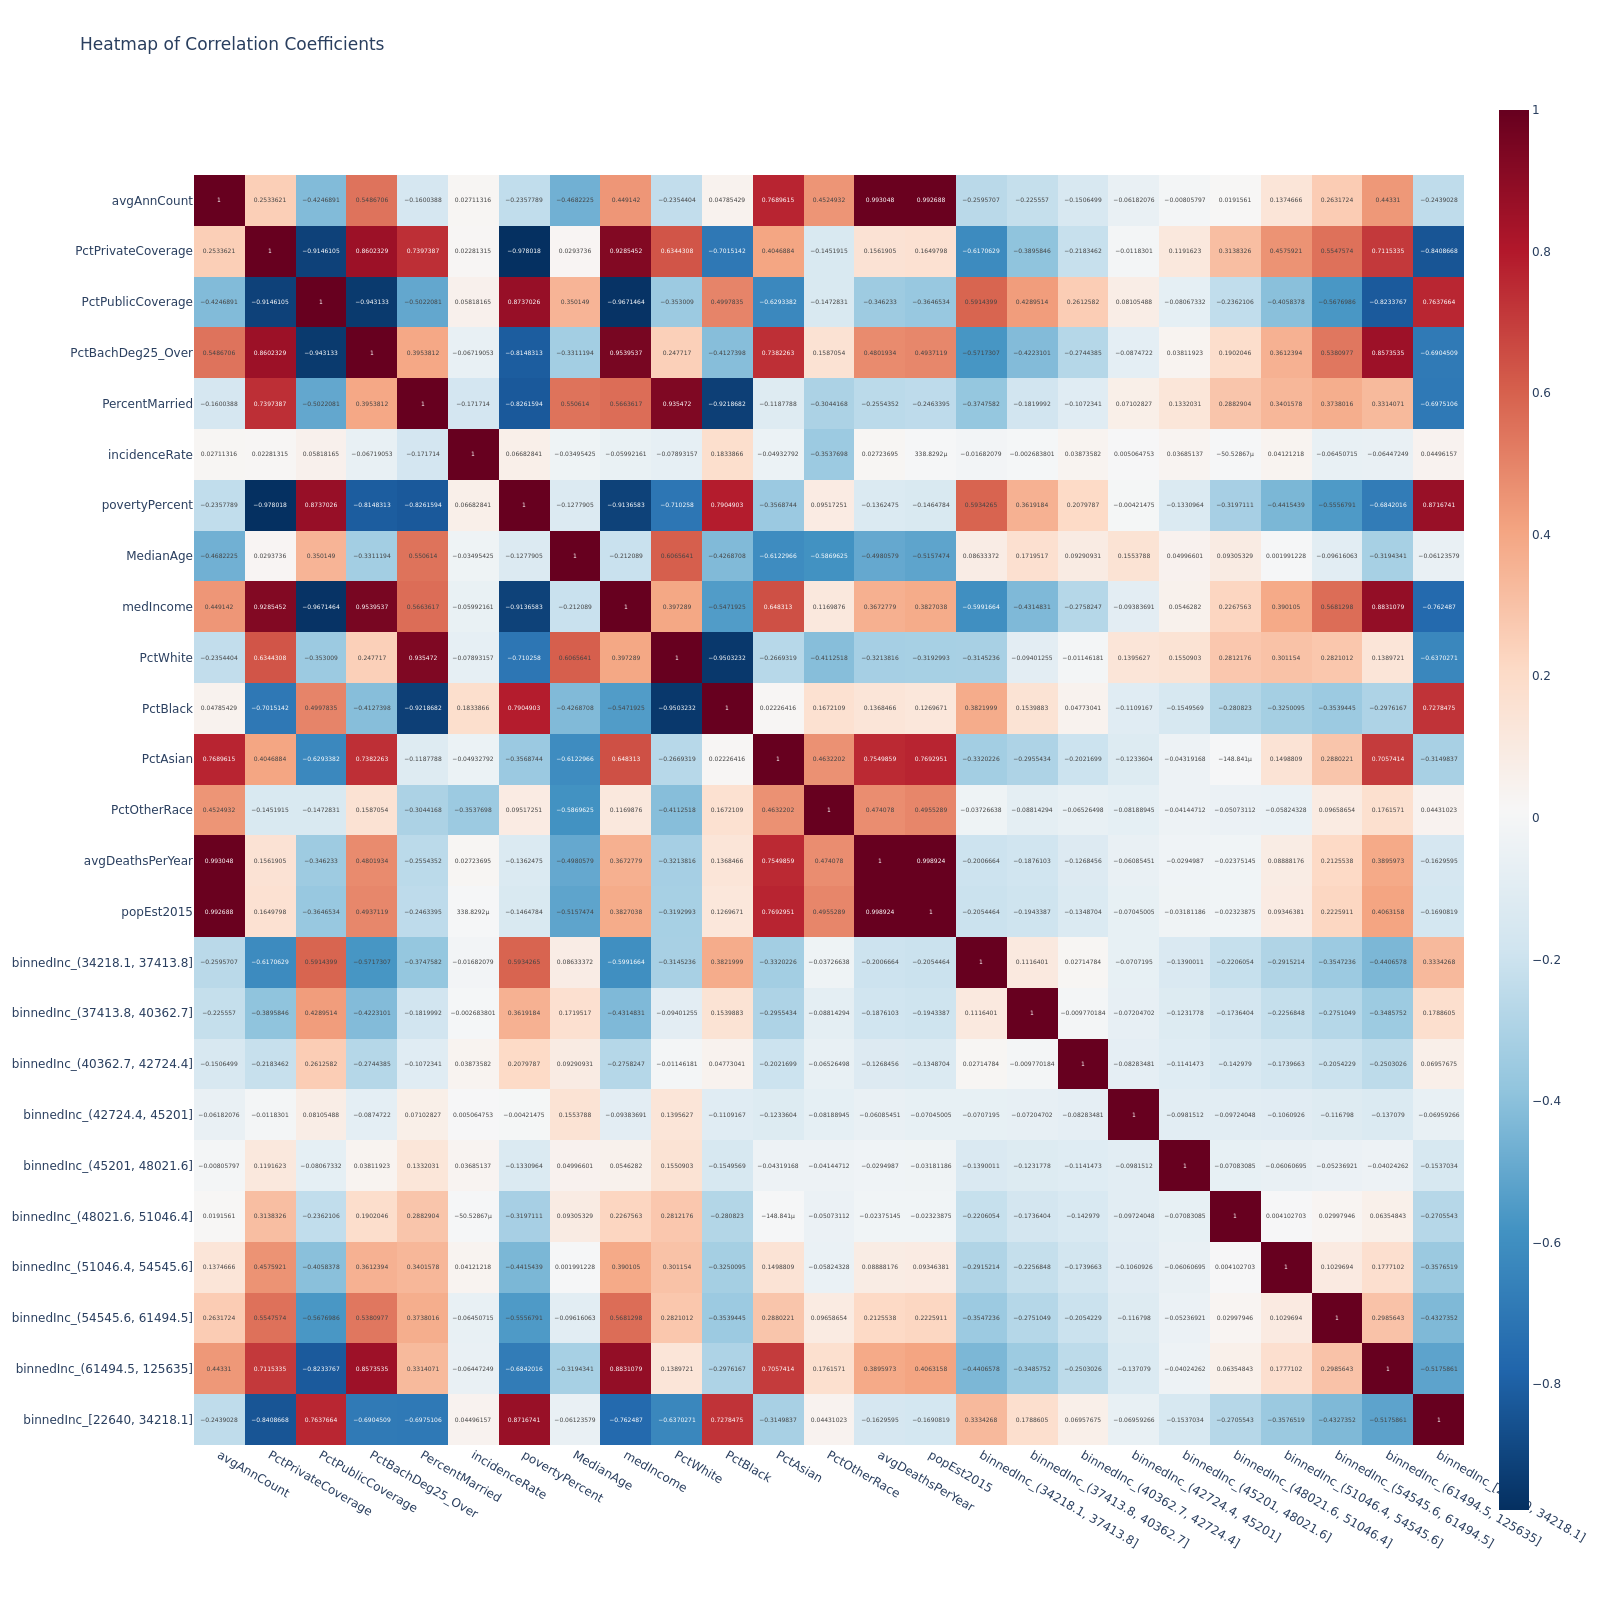

In [783]:
corr_heatmap(df[features_in].corr(numeric_only=True), fig_type="png")

Devido a desigualdade social, o percentual de negros pode se atrelar ao nível de pobreza. Por conta de serem de grupos diferentes, preferi remover do modelo e deixar somente o nível de pobreza!

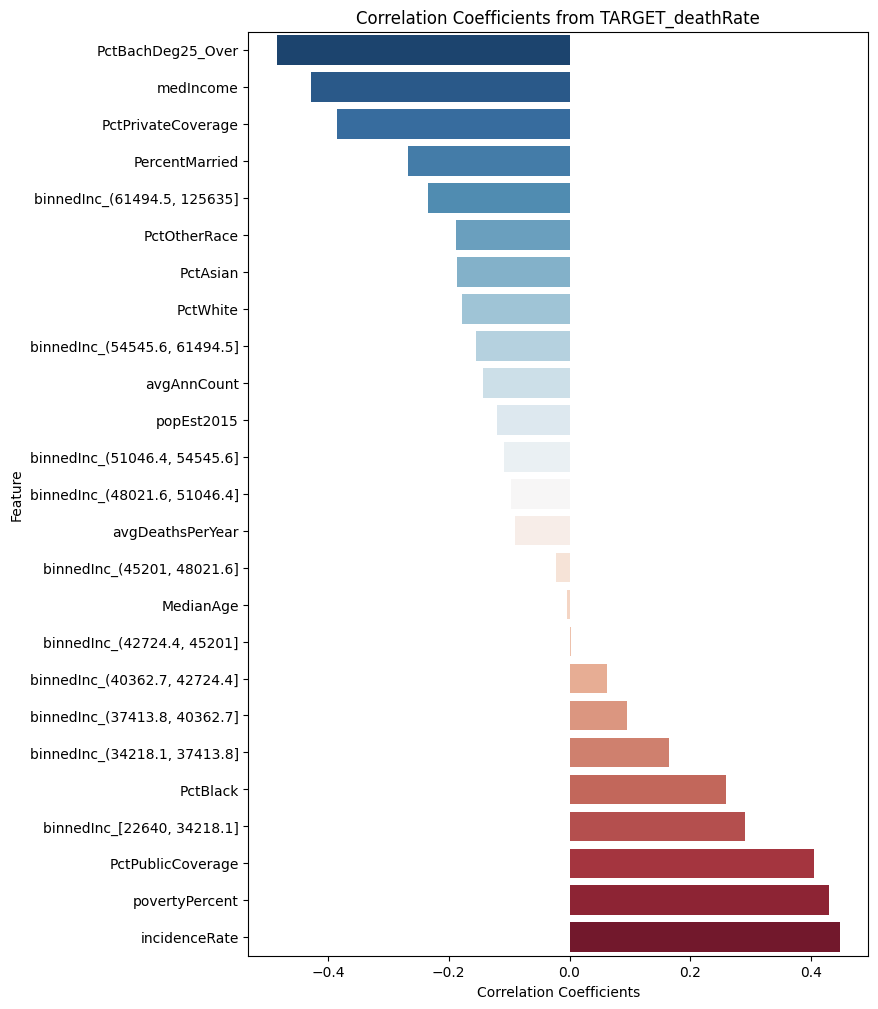

In [784]:
plot_barplot_corr_with_target(df[features_in + ['TARGET_deathRate']])

# Modeling

In [785]:
df_train, df_test = train_test_split(df[features_in + ['TARGET_deathRate']], test_size=0.3, random_state=42)

In [786]:
model = LinearRegression()

In [787]:
model.fit(df_train[features_in], df_train['TARGET_deathRate'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [788]:
y_pred = model.predict(df_test[features_in])
y_test = df_test['TARGET_deathRate']

## Testing Homoscedasticity

<Axes.ArtistList of 2 lines>

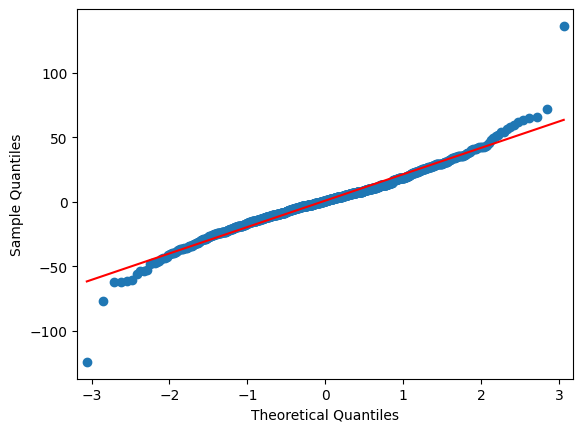

In [789]:
residuals = y_test - y_pred
qqplot(residuals, line='s').gca().lines

In [790]:
df_test[features_in]

,avgAnnCount,PctPrivateCoverage,PctPublicCoverage,PctBachDeg25_Over,PercentMarried,incidenceRate,povertyPercent,MedianAge,medIncome,PctWhite,...,"binnedInc_(34218.1, 37413.8]","binnedInc_(37413.8, 40362.7]","binnedInc_(40362.7, 42724.4]","binnedInc_(42724.4, 45201]","binnedInc_(45201, 48021.6]","binnedInc_(48021.6, 51046.4]","binnedInc_(51046.4, 54545.6]","binnedInc_(54545.6, 61494.5]","binnedInc_(61494.5, 125635]","binnedInc_[22640, 34218.1]"
1349,1962.667684,61.5,26.0,8.5,47.7,453.549422,15.7,29.4,47381,59.379565,...,0,0,0,0,1,0,0,0,0,0
1240,75.000000,56.8,41.7,8.2,53.6,376.200000,20.8,40.1,38975,74.872363,...,0,1,0,0,0,0,0,0,0,0
483,23.000000,75.9,35.5,15.7,58.5,436.000000,10.8,52.8,45040,96.292651,...,0,0,0,1,0,0,0,0,0,0
44,245.000000,56.1,45.5,5.5,53.1,523.900000,20.2,42.6,36437,96.445749,...,1,0,0,0,0,0,0,0,0,0
1080,80.000000,56.6,43.0,10.5,52.2,372.000000,17.4,45.0,39625,82.672551,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,16.000000,77.0,30.4,11.8,59.5,443.600000,13.7,44.4,48543,98.251069,...,0,0,0,0,0,1,0,0,0,0
527,455.000000,69.0,29.0,18.0,49.0,449.000000,14.7,31.6,51436,84.096260,...,0,0,0,0,0,0,1,0,0,0
1740,866.000000,70.6,31.6,14.9,49.6,460.100000,13.3,41.8,59492,78.098772,...,0,0,0,0,0,0,0,1,0,0
1073,52.000000,54.3,49.0,14.9,48.1,454.700000,22.0,53.5,32750,86.250384,...,0,0,0,0,0,0,0,0,0,1


In [791]:
# Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, df_test[features_in])
print("Goldfeld-Quandt test:")
print(f"F-stat: {gq_test[0]}, p-value: {gq_test[1]}\n")


Goldfeld-Quandt test:
F-stat: 1.049599228107666, p-value: 0.3083884178748519



## Testing VIF & Tolerance

In [792]:
def vif_rank(data):
    if 1 < data < 5:
        return "Low"
    elif 5 <= data < 10:
        return "Moderate"
    elif 10 <= data < 20:
        return "High"
    elif 20 <= data < 30:
        return "Very High"
    return "Extreme"

In [793]:
X = df_test[features_in]
vif_data = pd.DataFrame()
vif_data["feature"] = features_in
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["Tolerance"] = 1 / vif_data["VIF"]
vif_data["VIF Rank"] = vif_data["VIF"].apply(vif_rank)

In [794]:
vif_data

,feature,VIF,Tolerance,VIF Rank
0,avgAnnCount,14.128489,0.070779,High
1,PctPrivateCoverage,5.971944,0.167450,Moderate
2,PctPublicCoverage,6.196161,0.161390,Moderate
3,PctBachDeg25_Over,2.634258,0.379614,Low
4,PercentMarried,3.226517,0.309932,Low
5,incidenceRate,1.223204,0.817525,Low
6,povertyPercent,10.552313,0.094766,High
7,MedianAge,3.106666,0.321889,Low
8,medIncome,13.884909,0.072021,High
9,PctWhite,6.202672,0.161221,Moderate


In [795]:
def vif_with_target(df, features, target='povertyPercent'):
    vif_results = []
    for feat in features:
        if feat == target:
            continue
        X_pair = df[[target, feat]].dropna()
        vif = [variance_inflation_factor(X_pair.values, i) for i in range(X_pair.shape[1])]
        vif_results.append({'feature': feat, f'VIF_{target}': vif[1]})
    return pd.DataFrame(vif_results).sort_values(by=f'VIF_{target}', ascending=False)

vif_with_target(X, features_in, target='povertyPercent')

,feature,VIF_povertyPercent
2,PctPublicCoverage,14.422103
5,incidenceRate,7.559186
6,MedianAge,6.794641
4,PercentMarried,5.283841
8,PctWhite,4.521057
1,PctPrivateCoverage,4.385757
7,medIncome,3.440419
3,PctBachDeg25_Over,2.784712
9,PctBlack,1.765746
23,"binnedInc_[22640, 34218.1]",1.306025


In [796]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(418.99848066621684, 0.47355713920520914)

## RandomForestRegressor

Due to multicollinearity, others models should be better in the context

In [809]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True, max_depth=int(np.ceil(np.log2(len(df_train)) - 1)), min_samples_leaf=5)
rf.fit(df_train[features_in], df_train['TARGET_deathRate'])

,n_estimators,100
,criterion,'squared_error'
,max_depth,11
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [815]:
rf_y_pred = rf.predict(df_test[features_in])
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
rf_mse, rf_r2

(385.76488094233855, 0.5153128784750248)

In [813]:
feature_importances = pd.DataFrame(
            rf.feature_importances_,
            index=rf.feature_names_in_,
            columns=["importance"],
        ).sort_values("importance", ascending=False)

In [814]:
feature_importances

,importance
PctBachDeg25_Over,0.287836
incidenceRate,0.237000
medIncome,0.093382
PctPrivateCoverage,0.056203
avgDeathsPerYear,0.052324
PctOtherRace,0.037336
PctBlack,0.036194
povertyPercent,0.029285
PctPublicCoverage,0.027303
PercentMarried,0.026532


# Conformal Prediction